# Simplified detection of urban types


##### Example below illustrates the potential of morphometrics captured by momepy in capturing the structure of cities. We will pick a town, fetch its data from the OpenStreetMap, and analyse it to detect individual types of urban structure within it.

In [2]:
!pip install bokeh

In [3]:
!pip install clustergram

In [4]:
!pip install geopy

In [5]:
!pip install folium

#### Here, we will pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [6]:
import geopandas
import libpysal
import matplotlib.pyplot as plt
import momepy
import osmnx
import pandas
from bokeh.io import output_notebook
from bokeh.plotting import show
from clustergram import Clustergram
import geopy
import mapclassify
import folium

output_notebook()

Loading BokehJS ...

In [7]:
place="Znojmo, Czechia"
local_crs=5514

In [8]:
geopandas.tools.geocode(place).explore()

# Input data

#### We can use OSMnx to quickly download data from OpenStreetMap. If you intend to download larger areas, we recommend using pyrosm instead.

## Buildings

In [9]:
buildings = osmnx.features_from_place(place, tags={"building":True})
buildings.head()

geometry building bunker_type historic  \
element id                                                                    
node    3372076291  POINT (16.05376 48.84683)   bunker     pillbox      yes   
        3372076393  POINT (16.05581 48.84158)   bunker     pillbox      yes   
        3372076394  POINT (16.05867 48.83522)   bunker     pillbox      yes   
        3372076428  POINT (16.03949 48.85599)   bunker     pillbox      yes   
        3372076429  POINT (16.04133 48.85501)   bunker     pillbox      yes   

                   military            name ref:ropiky.net      source  \
element id                                                               
node    3372076291   bunker    7/I/10/A-120     1105625216  ropiky.net   
        3372076393   bunker  7/I/11/A-140 Z     1105625217  ropiky.net   
        3372076394   bunker    7/I/12/A-220     1105625218  ropiky.net   
        3372076428   bunker         7/I/8/E     1105625214  ropiky.net   
        3372076429   bunker         7/I/9/E     1105625215  ropiky.net   

                                                              website amenity  \
element id                                                                      
node    3372076291  https://ropiky.net/dbase_objekt.php?id=1105625216     NaN   
        3372076393  https://ropiky.net/dbase_objekt.php?id=1105625217     NaN   
        3372076394  https://ropiky.net/dbase_objekt.php?id=1105625218     NaN   
        3372076428  https://ropiky.net/dbase_objekt.php?id=1105625214     NaN   
        3372076429  https://ropiky.net/dbase_objekt.php?id=1105625215     NaN   

                    ... memorial ref:koda  ref monitoring:water_level  \
element id          ...                                                 
node    3372076291  ...      NaN      NaN  NaN                    NaN   
        3372076393  ...      NaN      NaN  NaN                    NaN   
        3372076394  ...      NaN      NaN  NaN                    NaN   
        3372076428  ...      NaN      NaN  NaN                    NaN   
        3372076429  ...      NaN      NaN  NaN                    NaN   

                   automated self_service shelter_type bridge:support  \
element id                                                              
node    3372076291       NaN          NaN          NaN            NaN   
        3372076393       NaN          NaN          NaN            NaN   
        3372076394       NaN          NaN          NaN            NaN   
        3372076428       NaN          NaN          NaN            NaN   
        3372076429       NaN          NaN          NaN            NaN   

                   construction type  
element id                            
node    3372076291          NaN  NaN  
        3372076393          NaN  NaN  
        3372076394          NaN  NaN  
        3372076428          NaN  NaN  
        3372076429          NaN  NaN  

[5 rows x 132 columns]

In [10]:
buildings.geom_type.value_counts()

Polygon    12297
Point          8
Name: count, dtype: int64

In [11]:
buildings = buildings[buildings.geom_type=="Polygon"].reset_index(drop=True)

##### Here, we are dropping unnecessary columns also we should re-project the data from WGS84 to the local projection in meters.


In [12]:
buildings=buildings[["geometry"]].to_crs(local_crs)
buildings.head()

,geometry
0,"POLYGON ((-642818.791 -1194246.301, -642822.90..."
1,"POLYGON ((-643052.212 -1193474.914, -643069.77..."
2,"POLYGON ((-642796.708 -1193674.586, -642795.74..."
3,"POLYGON ((-642960.567 -1193475.288, -642969.02..."
4,"POLYGON ((-642973.521 -1193481.346, -642960.58..."


## Streets

### Similar operations are done with streets.

In [13]:
osm_graph=osmnx.graph_from_place(place, network_type="drive")
osm_graph=osmnx.projection.project_graph(osm_graph, to_crs=local_crs)
streets=osmnx.graph_to_gdfs(
    osmnx.convert.to_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
).reset_index(drop=True)
streets.head()

,osmid,highway,maxspeed,name,ref,oneway,reversed,length,from,to,geometry,lanes,bridge,width,junction,tunnel,access
0,33733060,secondary,50,Přímětická,361,False,True,24.573585,639231391,74103628,"LINESTRING (-643229.639 -1192872.949, -643239....",NaN,NaN,NaN,NaN,NaN,NaN
1,33733060,secondary,50,Přímětická,361,False,False,60.345697,3775990798,74103628,"LINESTRING (-643236.395 -1192790.304, -643236....",NaN,NaN,NaN,NaN,NaN,NaN
2,50313252,residential,NaN,Raisova,NaN,True,False,74.762885,639231413,74103628,"LINESTRING (-643291.344 -1192797.012, -643288....",NaN,NaN,NaN,NaN,NaN,NaN
3,33733060,secondary,50,Přímětická,361,False,True,54.260241,74142638,639231391,"LINESTRING (-643205.434 -1192921.533, -643219....",NaN,NaN,NaN,NaN,NaN,NaN
4,50313241,residential,NaN,Mičurinova,NaN,True,False,101.376850,639231391,639231314,"LINESTRING (-643229.639 -1192872.949, -643233....",NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
streets=momepy.remove_false_nodes(streets)
streets=streets[["geometry"]]
streets.head()

,geometry
0,"LINESTRING (-643229.639 -1192872.949, -643239...."
1,"LINESTRING (-643236.395 -1192790.304, -643236...."
2,"LINESTRING (-643291.344 -1192797.012, -643288...."
3,"LINESTRING (-643205.434 -1192921.533, -643219...."
4,"LINESTRING (-643229.639 -1192872.949, -643233...."


## Generated data

### Tessellation

##### Given building footprints:

In [16]:
buildings = geopandas.read_file(
    momepy.datasets.get_path("bubenec"), layer="buildings"
)

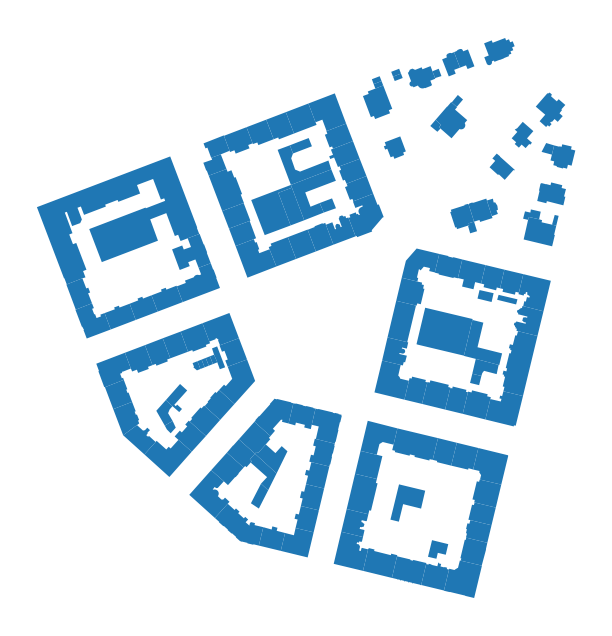

In [17]:
ax = buildings.plot(figsize=(8, 8))
ax.set_axis_off()

In [18]:
import osmnx as ox

gdf = ox.features_from_place("Kahla, Germany", tags={"building": True})
gdf_projected = ox.projection.project_gdf(gdf)

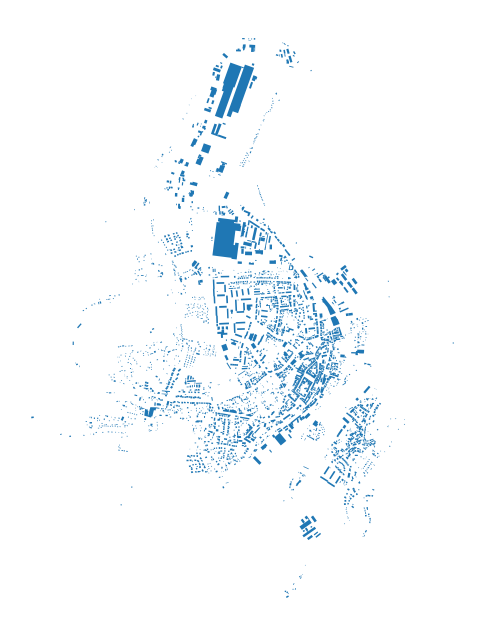

In [19]:
ax = gdf_projected.plot(figsize=(8, 8))
ax.set_axis_off()

#### Here, we are generating a spatial unit using morphological tesellation.

In [20]:
limit = momepy.buffered_limit(buildings, "adaptive")

tessellation = momepy.morphological_tessellation(buildings, clip=limit)

#### OpenStreetMap data are often problematic due to low quality of some polygons. If some collapse, we get a mismatch between the length of buildings and the length of polygons. 

In [23]:
collapsed, _ = momepy.verify_tessellation(tessellation, buildings)


#### We prefer to drop affected buildings and re-create tessellation.

In [24]:
buildings = buildings.drop(collapsed)
limit = momepy.buffered_limit(buildings, "adaptive")
tessellation = momepy.morphological_tessellation(buildings, clip=limit)

In [25]:
tessellation.shape[0] == buildings.shape[0]

True